# Intro

Цель данного эксперимента заключается в разработке полного пайплайна компьютерного зрения на основе Vision Transformer (ViT) — от подготовки данных и настройки обучения до анализа внутренних механизмов модели - который позволил бы применить предобученную модель на классификации конкретных классов целевых данных в результате fine-tuning

In [1]:
# PyTorch
import torch
import torchvision
from torchvision.transforms import Normalize, Resize, ToTensor, Compose
# For dislaying images
from PIL import Image
import matplotlib.pyplot as plt
from torchvision.transforms import ToPILImage
# Loading dataset
from datasets import load_dataset
# Transformers
from transformers import ViTImageProcessor, ViTForImageClassification, ViTModel
from transformers import TrainingArguments, Trainer
# Matrix operations
import numpy as np
# Evaluation
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


2025-11-03 07:12:01.162887: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762153921.363047      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762153921.421852      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Create datasets

## Load data

In [2]:
# Load data
df_train, df_test = load_dataset("cifar10", split=["train[:5000]","test[:1000]"])
splits = df_train.train_test_split(test_size=0.1)
df_train = splits['train']
df_valid = splits['test']
df_train, df_valid, df_test

README.md: 0.00B [00:00, ?B/s]

plain_text/train-00000-of-00001.parquet:   0%|          | 0.00/120M [00:00<?, ?B/s]

plain_text/test-00000-of-00001.parquet:   0%|          | 0.00/23.9M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

(Dataset({
     features: ['img', 'label'],
     num_rows: 4500
 }),
 Dataset({
     features: ['img', 'label'],
     num_rows: 500
 }),
 Dataset({
     features: ['img', 'label'],
     num_rows: 1000
 }))

In [3]:
df_train.features, df_train.num_rows, df_train[0]


({'img': Image(mode=None, decode=True),
  'label': ClassLabel(names=['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])},
 4500,
 {'img': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=32x32>,
  'label': 3})

## Get classes

In [4]:
itos = dict((k,v) for k,v in enumerate(df_train.features['label'].names))
stoi = dict((v,k) for k,v in enumerate(df_train.features['label'].names))
itos

{0: 'airplane',
 1: 'automobile',
 2: 'bird',
 3: 'cat',
 4: 'deer',
 5: 'dog',
 6: 'frog',
 7: 'horse',
 8: 'ship',
 9: 'truck'}

truck


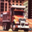

In [5]:
import random

index = random.randint(0, 9)
img, lab = df_train[index]['img'], itos[df_train[index]['label']]
print(lab)
img

## Preprocess datasets

In [6]:
model_name = "google/vit-base-patch16-224"
processor = ViTImageProcessor.from_pretrained(model_name)

mu, sigma = processor.image_mean, processor.image_std #get default mu,sigma
size = processor.size

size

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

{'height': 224, 'width': 224}

In [7]:
norm = Normalize(mean=mu, std=sigma) # normalize image pixels range to [-1,1]

_transf = Compose([
    Resize(size['height']), # resize 3x32x32 to 3x224x224
    ToTensor(),             # convert to Pytorch tensor
    norm                    # normalize
])

# apply transforms to PIL Image and store it to 'pixels' key
def transf(arg):
    arg['pixels'] = [_transf(image.convert('RGB')) for image in arg['img']]
    return arg

# Transform
df_train.set_transform(transf)
df_valid.set_transform(transf)
df_test.set_transform(transf)

In [8]:
df_train.shape[0]

4500

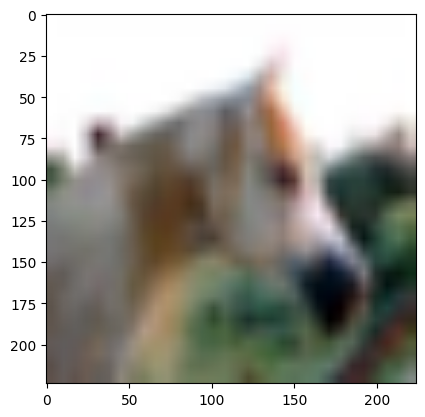

In [9]:
idx = random.randint(0, df_train.shape[0]-1)
ex = df_train[idx]['pixels']
ex = (ex+1)/2 # imshow requires image pixels to be in the range [0,1]
exi = ToPILImage()(ex)

plt.imshow(exi)
plt.show()

# Model fine-tuning

## Traning

In [10]:
model_name = "google/vit-base-patch16-224"
model = ViTForImageClassification.from_pretrained(model_name, num_labels=10, ignore_mismatched_sizes=True, id2label=itos, label2id=stoi)
print(model.classifier)

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([10]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([10, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Linear(in_features=768, out_features=10, bias=True)


In [13]:
args = TrainingArguments(
    f"test-cifar-10",
    # save and evaluates model after every epoch
    save_strategy="epoch",
    eval_strategy="epoch",
    # regularization params
    learning_rate=2e-5,
    per_device_train_batch_size=10,
    per_device_eval_batch_size=4,
    num_train_epochs=5,
    weight_decay=0.01,
    load_best_model_at_end=True, # keep necessary dataset columns (like image pixels)
    metric_for_best_model="accuracy",
    logging_dir='logs', # logging directory
    remove_unused_columns=False,
    report_to=['tensorboard'] # for dashboard
)

In [14]:
def collate_fn(examples):
    '''
    Prepares batches for training by stacking pixel tensors
    and labels into batches and converts list of examples
    to batched tensors for the model's expected input
    '''
    pixels = torch.stack([example["pixels"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixels, "labels": labels}

def compute_metrics(eval_pred):
    '''
    Takes model predictions and true labels to compute classification
    accuracy for using during evaluation after each epoch.
    '''
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return dict(accuracy=accuracy_score(predictions, labels))

In [15]:
# Wraps model, training config, datasets, and utility functions into Hugging Face’s Trainer.

trainer = Trainer(
    model,
    args,
    train_dataset=df_train,
    eval_dataset=df_valid,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    tokenizer=processor,
)

/tmp/ipykernel_37/1580766989.py:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [16]:
trainer.train()


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.088311,0.976000
2,No log,0.065556,0.982000
3,0.289300,0.059454,0.978000
4,0.289300,0.066338,0.980000
5,0.004000,0.067048,0.978000


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


TrainOutput(global_step=1125, training_loss=0.130580048388905, metrics={'train_runtime': 605.2125, 'train_samples_per_second': 37.177, 'train_steps_per_second': 1.859, 'total_flos': 1.74369478284288e+18, 'train_loss': 0.130580048388905, 'epoch': 5.0})

## Evaluate

In [17]:
outputs = trainer.predict(df_test)
print(outputs.metrics)

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'test_loss': 0.08037389814853668, 'test_accuracy': 0.973, 'test_runtime': 10.7564, 'test_samples_per_second': 92.968, 'test_steps_per_second': 11.621}


In [18]:
# Compare with not tuning model

from tqdm import tqdm
from sklearn.metrics import accuracy_score

def evaluate_model(model, dataloader):
    all_preds = []
    all_labels = []

    model_name = "google/vit-base-patch16-224"
    model = ViTForImageClassification.from_pretrained(model_name, num_labels=10, ignore_mismatched_sizes=True, id2label=itos, label2id=stoi)

    for batch in tqdm(dataloader):
        labels = batch["label"]
        pixel_values = batch["pixels"].unsqueeze(0)
        with torch.no_grad():
            outputs = model(pixel_values)
        preds = outputs.logits.argmax(dim=-1)
        all_preds.append(preds)
        all_labels.append(labels)
    return accuracy_score(all_labels, all_preds)

evaluate_model(model, df_test)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([10]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([10, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 1000/1000 [03:13<00:00,  5.16it/s]


0.104

In [19]:
idx = random.randint(0, outputs.predictions.shape[0]-1)
itos[np.argmax(outputs.predictions[idx])], itos[outputs.label_ids[idx]]


('truck', 'truck')

In [20]:
trainer.save_model("ft_best_model")

# Results visualization

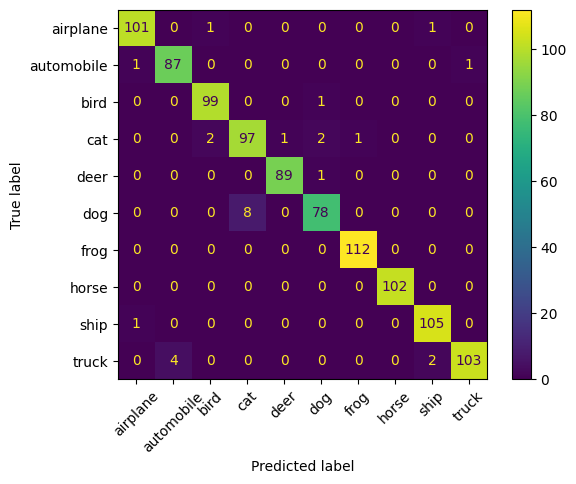

In [21]:
y_true = outputs.label_ids
y_pred = outputs.predictions.argmax(1)

labels = df_train.features['label'].names
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(xticks_rotation=45)

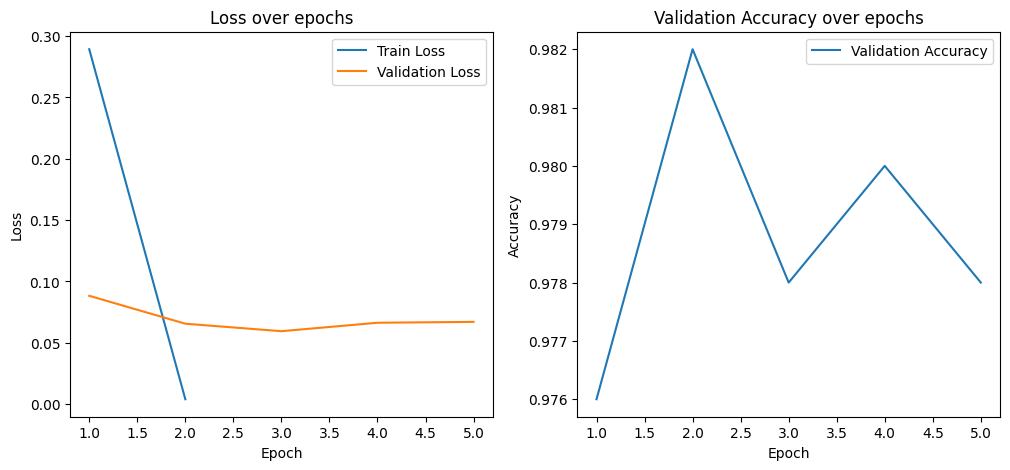

In [22]:
import matplotlib.pyplot as plt

log_history = trainer.state.log_history

train_loss = [x['loss'] for x in log_history if 'loss' in x]
eval_loss = [x['eval_loss'] for x in log_history if 'eval_loss' in x]
eval_accuracy = [x['eval_accuracy'] for x in log_history if 'eval_accuracy' in x]

plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_loss)+1), train_loss, label='Train Loss')
plt.plot(range(1, len(eval_loss)+1), eval_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss over epochs')

plt.subplot(1, 2, 2)
plt.plot(range(1, len(eval_accuracy)+1), eval_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Validation Accuracy over epochs')

plt.show()


In [23]:
%load_ext tensorboard
%tensorboard --logdir logs

<IPython.core.display.Javascript object>

**Архитектура, гиперпараметры, выбранные решения:**

Был разработан пайплайн по классификации 10 классов на изображениях на основе ViT архитектуры.
В рамках задачи был выбран открытый датасет CIFAR-10, разбитый на 3 выборки: тренировочную, валидационную и тестовую.  Изображения были предобработаны и трансформированы согласно целевому размеру.

Fine-tuning производился на модели `google/vit-base-patch16-224`. Модель тюнилась на `5` эпохах. Были заданы параметры скорости обучения `2e-5`, размера батча `10`, уменьшения веса  `0.01` в рамках регуляризации. В качестве метрики была выбрана `accuracy`

**Анализ обучения и итоговой модели**

Loss на валидационной выборке снизился на первых эпохах, а далее был стабилен, что свидетельствует об улучшении обобщения. Такой стабильно низкий уровень потерь при валидации свидетельствует о том, что модель не слишком переобучается. Точность также весьма стабильна на протяжении всего обучени с небольшими естественными флуктуациями.

Финальная проверка на тестовом датасете доказывает стабильность модели:
>'test_loss': 0.08037389814853668, 

>'test_accuracy': 0.973

# Attansion vizualization

## Fine_tuning model

In [24]:
model = ViTForImageClassification.from_pretrained("ft_best_model", output_attentions=True)
model

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out_features=3072, bias=True)
            (intermed

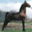

In [78]:
idx = 32
df_train[idx]['img']

In [79]:
# Img plus batch dimension
img = df_train[idx]['pixels'].unsqueeze(0)

model.eval()
with torch.no_grad():
    outputs = model.vit(img, output_attentions=True)

attentions = outputs.attentions

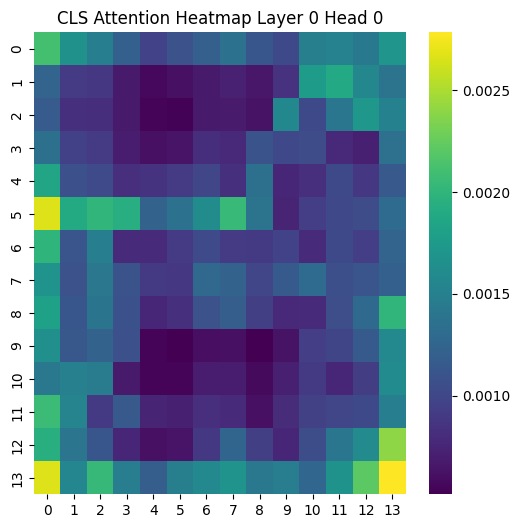

In [80]:
import seaborn as sns
import cv2

def plot_cls_attention(attentions, layer=0, head=0, is_interp=False):
    # Select attention matrix from the chosen layer and head
    attn = attentions[layer][0, head]  # shape (seq_len, seq_len)

    # CLS token attention weights to patches (exclude CLS itself if desired)
    cls_attn = attn[0, 1:]  # 1: excludes CLS itself

    # Reshape to patch grid (assume 14x14 patches for 224x224 input with 16 patch size)
    size = int(cls_attn.size(0) ** 0.5)
    cls_attn = cls_attn.reshape(size, size).cpu().numpy()

    if is_interp:
        cls_attn = cv2.resize(cls_attn, (14, 14), interpolation=cv2.INTER_CUBIC)

    # Plot heatmap
    plt.figure(figsize=(6,6))
    sns.heatmap(cls_attn, cmap='viridis')
    plt.title(f'CLS Attention Heatmap Layer {layer} Head {head}')
    plt.show()

plot_cls_attention(attentions, layer=0, head=0)


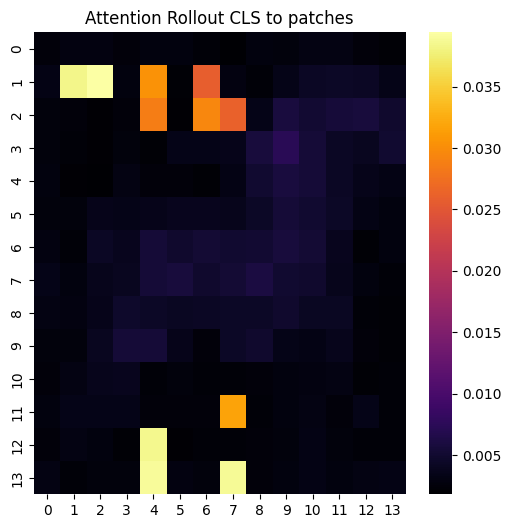

In [81]:
def attention_rollout(attentions, discard_ratio=0.0, is_interp=False):
    '''
    attentions: tuple of (num_layers) (batch_size, num_heads, seq_len, seq_len)

    Aggregate heads by mean, remove CLS token row and column, apply discard ratio to reduce noise
    '''

    result = torch.eye(attentions[0].size(-1))
    for layer_attn in attentions:
        # Average heads
        attn_heads_fused = layer_attn[0].mean(dim=0)  # (seq_len, seq_len)

        # Optionally discard low attentions
        flat = attn_heads_fused.view(-1)
        threshold = torch.quantile(flat, discard_ratio)
        attn_heads_fused = torch.where(attn_heads_fused < threshold, torch.zeros_like(attn_heads_fused), attn_heads_fused)

        # Adding identity to preserve residual connection and normalize
        attn_heads_fused += torch.eye(attn_heads_fused.size(0))
        attn_heads_fused /= attn_heads_fused.sum(dim=-1, keepdim=True)

        result = torch.matmul(result, attn_heads_fused)

    size = int(result.size(0) ** 0.5)
    cls_rollout = result[0, 1:].reshape(size,size).cpu().numpy()

    if is_interp:
        cls_rollout = cv2.resize(cls_rollout, (14, 14), interpolation=cv2.INTER_CUBIC)

    # Visualize CLS rollout attention to patches (exclude CLS token itself)
    plt.figure(figsize=(6,6))
    sns.heatmap(cls_rollout, cmap='inferno')
    plt.title('Attention Rollout CLS to patches')
    plt.show()
    return result

rollout_attn = attention_rollout(attentions)

Attention Rollout последовательно перемножает матрицы внимания всех слоёв. Таким образом, он учитывает как прямое, так и косвенное влияние каждого патча на CLS-токен через все промежуточные слои. Мы можем видеть матрицу, где для CLS-токена рассчитана совокупная важность каждого патча с учётом всей глубины модели.

Мы можем видеть, что для общего приянтия решения модель фокусируется как на ключевых деталях объекта, так и на некоторых участках фона

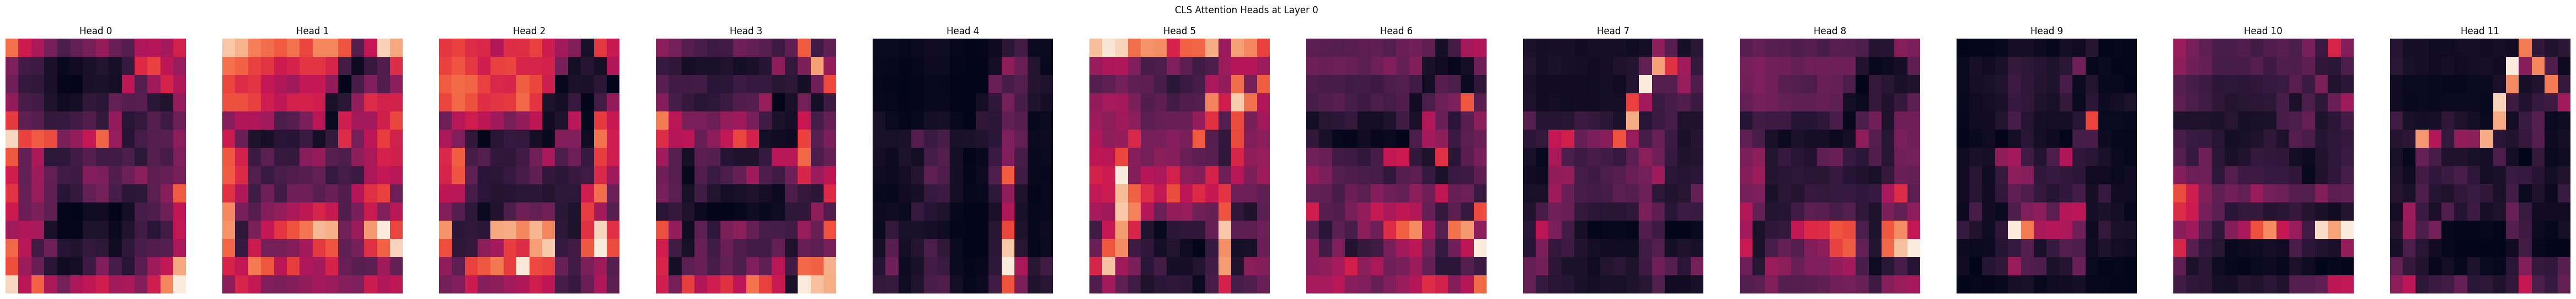

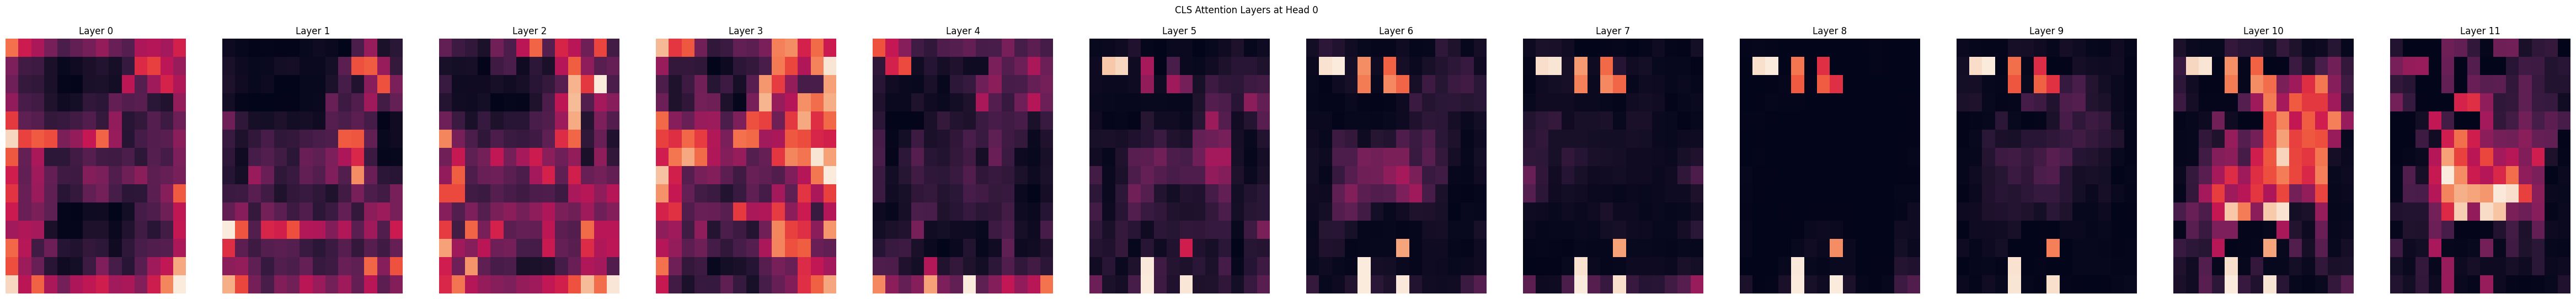

In [82]:
def plot_heads_attention(attentions, layer=0, is_interp=False):
    heads = attentions[layer].size(1)
    size = int((attentions[layer].size(-1)-1) ** 0.5)

    fig, axs = plt.subplots(1, heads, figsize=(heads*5, 6))
    for head in range(heads):
        attn = attentions[layer][0, head]
        cls_attn = attn[0,1:].reshape(size, size).cpu().numpy()
        if is_interp:
            cls_attn = cv2.resize(cls_attn, (14, 14), interpolation=cv2.INTER_CUBIC)
        sns.heatmap(cls_attn, ax=axs[head], cbar=False)
        axs[head].set_title(f'Head {head}')
        axs[head].axis('off')
    plt.suptitle(f'CLS Attention Heads at Layer {layer}')
    plt.show()

def plot_layers_attention(attentions, head=0, is_interp=False):
    layers = len(attentions)
    size = int((attentions[0].size(-1)-1) ** 0.5)

    fig, axs = plt.subplots(1, layers, figsize=(layers*5, 6))
    for layer in range(layers):
        attn = attentions[layer][0, head]
        cls_attn = attn[0,1:].reshape(size, size).cpu().numpy()
        if is_interp:
            cls_attn = cv2.resize(cls_attn, (14, 14), interpolation=cv2.INTER_CUBIC)
        sns.heatmap(cls_attn, ax=axs[layer], cbar=False)
        axs[layer].set_title(f'Layer {layer}')
        axs[layer].axis('off')
    plt.suptitle(f'CLS Attention Layers at Head {head}')
    plt.show()

# Example usage:
plot_heads_attention(attentions, layer=0)
plot_layers_attention(attentions, head=0)


Мы можем видеть распределение внимания CLS-токена к отдельным патчам изображения. По головам внимания видно разнообразие фокусов — одни головы акцентируют внимание на краях объектов, другие — на центрах или фоновых патчах.

С ростом номера слоя происходит постепенное сужение области внимания, что соответствует этапам обработки информации: от общего восприятия к детальному.


## Interpolated model

Попробуем интерполировать нашу модель до размера датасета

In [83]:
import torch
import torch.nn.functional as F
from transformers import ViTModel, ViTConfig

def interpolate_positional_embeddings(model, new_grid_size):
    # get position embeddings (shape: (1, old_num_patches+1, dim))
    pos_embed = model.vit.embeddings.position_embeddings
    num_patches = (pos_embed.shape[1] - 1)
    dim = pos_embed.shape[2]

    old_size = int(num_patches ** 0.5)
    assert old_size * old_size == num_patches, "Unexpected position embedding shape"

    # split CLS tokens and pos embs
    cls_token = pos_embed[:, 0:1, :]
    patch_pos_embed = pos_embed[:, 1:, :]

    # change to 2d and interpolate to new size
    patch_pos_embed = patch_pos_embed.reshape(1, old_size, old_size, dim).permute(0, 3, 1, 2)  # (1, dim, old_size, old_size)
    patch_pos_embed = F.interpolate(patch_pos_embed, size=new_grid_size, mode='bicubic', align_corners=False)
    patch_pos_embed = patch_pos_embed.permute(0, 2, 3, 1).reshape(1, new_grid_size[0]*new_grid_size[1], dim)

    # merge CLS token and new patch-embs and save to the model
    new_pos_embed = torch.cat((cls_token, patch_pos_embed), dim=1)
    model.vit.embeddings.position_embeddings = torch.nn.Parameter(new_pos_embed)


new_grid_size = tuple(int(i/16) for i in df_train[0]['img'].size)
new_image_size = df_train[0]['img'].size[0]

config_model = ViTConfig.from_pretrained("ft_best_model")
config_model.image_size = new_image_size
config_model.output_attentions = True
config_model._attn_implementation = "eager"

interpolated_model = ViTForImageClassification(config_model)
interpolate_positional_embeddings(interpolated_model, new_grid_size)

interpolated_model



ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out_features=3072, bias=True)
            (intermed

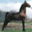

/usr/local/lib/python3.11/dist-packages/transformers/models/vit/feature_extraction_vit.py:30: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [84]:
from transformers import ViTFeatureExtractor

# Img plus batch dimension
img = df_train[idx]['img']
display(img)
new_image_size = img.size[0]

feature_extractor = ViTFeatureExtractor.from_pretrained('ft_best_model', size=new_image_size)
inputs = feature_extractor(images=img, return_tensors="pt")

interpolated_model.eval()
with torch.no_grad():
    interp_outputs = interpolated_model(**inputs, output_attentions=True)

interp_attentions = interp_outputs.attentions

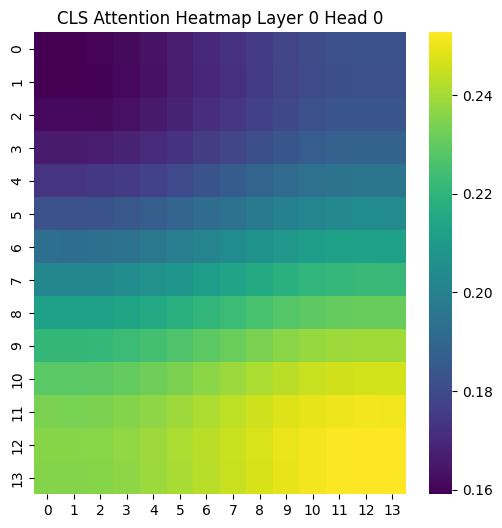

In [85]:
plot_cls_attention(interp_attentions, layer=0, head=0, is_interp=True)

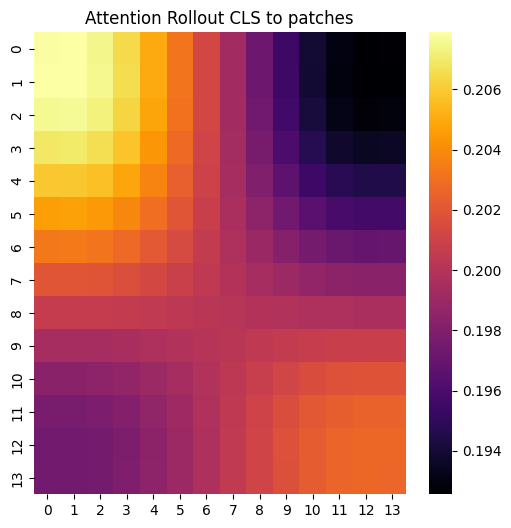

In [86]:
rollout_attn = attention_rollout(interp_attentions, is_interp=True)

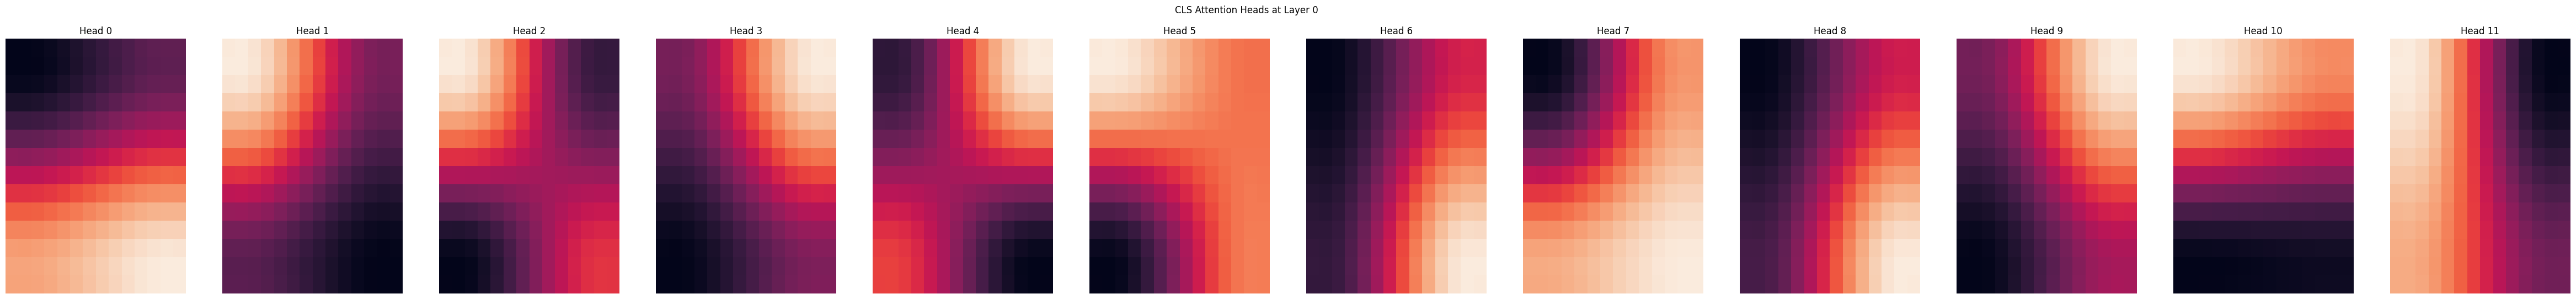

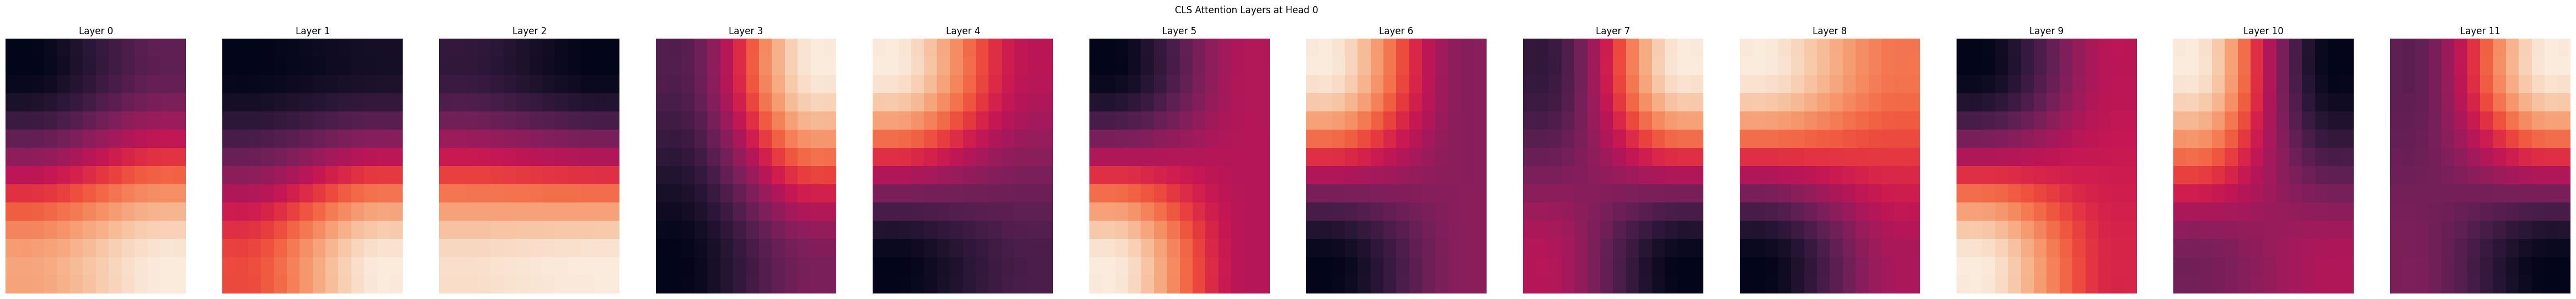

In [87]:
plot_heads_attention(interp_attentions, layer=0, is_interp=True)
plot_layers_attention(interp_attentions, head=0, is_interp=True)

# Conclusion

Сильные стороны алгоритма:
- ViT эффективно выделяет ключевые области изображения благодаря механизму внимания, что облегчает интерпретацию решений модели.
- Множество голов позволяет модели параллельно фокусироваться на разных аспектах изображения, повышая общий выразительный потенциал.
- Возможность масштабирования на разные разрешения с корректной интерполяцией позиционных эмбеддингов сохраняет качество предсказаний.

Слабые стороны алгоритма:
- Модель чувствительна к качеству и размеру патчей
- Изменения разрешения требуют аккуратного управления позиционными эмбеддингами, иначе может ухудшиться качество.
Все это подтверждает и визуализация слоев внимания на интерполированной модели и дефолтном размере изображения

Таким образом, благодаря fine-tuning удалось успешно дообучить модель на целевых данных под задачу классификации 10 классов с достаточно высокой метрикой в 0.97 accuracy